In [1]:
import os
import pandas as pd
import cv2
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Base directories
base_dir = "lisa_raw"
processed_dir = "processed"   # Cropped traffic lights
dataset_dir = "dataset"       # Train/Val/Test split
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(dataset_dir, exist_ok=True)

# Tags to process
tags = ["stop", "go", "warning"]

# Ensure output subfolders exist
for tag in tags:
    os.makedirs(os.path.join(processed_dir, tag), exist_ok=True)


2025-09-03 00:58:52.251245: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-03 00:58:52.251284: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-03 00:58:52.251310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-03 00:58:52.257968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-03 00:58:52.989038: W tensorflow/compiler/

In [12]:
import os

# Base directory
base_dir = "lisa_raw"

# List of sequences with annotation file and frames folder
sequences = [
    {"name": "daySequence1",
     "ann": os.path.join(base_dir, "Annotations/Annotations/daySequence1/frameAnnotationsBOX.csv"),
     "frames": os.path.join(base_dir, "daySequence1/daySequence1/frames")},
    
    {"name": "daySequence2",
     "ann": os.path.join(base_dir, "Annotations/Annotations/daySequence2/frameAnnotationsBOX.csv"),
     "frames": os.path.join(base_dir, "daySequence2/daySequence2/frames")},
    
    {"name": "dayClip1",
     "ann": os.path.join(base_dir, "Annotations/Annotations/dayTrain/dayClip1/frameAnnotationsBOX.csv"),
     "frames": os.path.join(base_dir, "dayTrain/dayTrain/dayClip1/frames")},
    
    {"name": "dayClip2",
     "ann": os.path.join(base_dir, "Annotations/Annotations/dayTrain/dayClip2/frameAnnotationsBOX.csv"),
     "frames": os.path.join(base_dir, "dayTrain/dayTrain/dayClip2/frames")},
    
    {"name": "dayClip3",
     "ann": os.path.join(base_dir, "Annotations/Annotations/dayTrain/dayClip3/frameAnnotationsBOX.csv"),
     "frames": os.path.join(base_dir, "dayTrain/dayTrain/dayClip3/frames")},

    {"name": "dayClip4",
     "ann": os.path.join(base_dir, "Annotations/Annotations/dayTrain/dayClip4/frameAnnotationsBOX.csv"),
     "frames": os.path.join(base_dir, "dayTrain/dayTrain/dayClip4/frames")},

    {"name": "dayClip5",
     "ann": os.path.join(base_dir, "Annotations/Annotations/dayTrain/dayClip5/frameAnnotationsBOX.csv"),
     "frames": os.path.join(base_dir, "dayTrain/dayTrain/dayClip5/frames")},
]

# Check image folders exist
for seq in sequences:
    if not os.path.exists(seq["frames"]):
        print(f"⚠️ Missing folder for {seq['name']}: {seq['frames']}")
    elif not os.path.exists(seq["ann"]):
        print(f"⚠️ Missing annotation file for {seq['name']}: {seq['ann']}")
    else:
        print(f"✅ Found folder and annotation for {seq['name']}")

✅ Found folder and annotation for daySequence1
✅ Found folder and annotation for daySequence2
✅ Found folder and annotation for dayClip1
✅ Found folder and annotation for dayClip2
✅ Found folder and annotation for dayClip3
✅ Found folder and annotation for dayClip4
✅ Found folder and annotation for dayClip5


In [13]:
import os
import pandas as pd
import cv2
from tqdm import tqdm

# Base directories
base_dir = "lisa_raw"
processed_dir = "processed"
dataset_dir = "dataset"
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(dataset_dir, exist_ok=True)

# Tags to process
tags = ["stop", "go", "warning"]

# Ensure output subfolders exist
for tag in tags:
    os.makedirs(os.path.join(processed_dir, tag), exist_ok=True)

# Process sequences
for seq in sequences:
    ann_path = seq["ann"]
    img_dir = seq["frames"]
    
    if not os.path.exists(ann_path):
        print(f"⚠️ Missing annotation file for {seq['name']}, skipping")
        continue

    try:
        df = pd.read_csv(ann_path, sep=";")
    except Exception as e:
        print(f"⚠️ Error reading {ann_path}: {e}")
        continue

    processed_count = 0
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {seq['name']}"):
        filename = os.path.basename(row["Filename"])
        img_path = os.path.join(img_dir, filename)

        if not os.path.exists(img_path):
            continue  # Skip missing files

        tag = row["Annotation tag"].strip().lower()
        if tag not in tags:
            continue  # Skip unknown tags

        save_path = os.path.join(processed_dir, tag, f"{seq['name']}_{filename}")
        if os.path.exists(save_path):
            continue  # Skip if already exists

        img = cv2.imread(img_path)
        if img is None:
            continue

        x1, y1, x2, y2 = int(row["Upper left corner X"]), int(row["Upper left corner Y"]), \
                         int(row["Lower right corner X"]), int(row["Lower right corner Y"])

        # Validate coordinates
        h, w = img.shape[:2]
        if x1 < 0 or y1 < 0 or x2 > w or y2 > h or x1 >= x2 or y1 >= y2:
            continue

        crop = img[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        try:
            cv2.imwrite(save_path, crop)
            processed_count += 1
        except Exception as e:
            print(f"⚠️ Error saving {save_path}: {e}")
            continue

    print(f"Processed {processed_count} images for {seq['name']}")

# Summary
for tag in tags:
    folder = os.path.join(processed_dir, tag)
    images = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.png', '.jpeg'))] if os.path.exists(folder) else []
    print(f"{tag}: {len(images)} images")

print("✅ Dataset prepared successfully.")

Processing daySequence1:   0%|          | 0/7900 [00:00<?, ?it/s]

Processing daySequence1: 100%|██████████| 7900/7900 [00:16<00:00, 486.91it/s]


Processed 3496 images for daySequence1


Processing daySequence2: 100%|██████████| 10120/10120 [00:17<00:00, 567.09it/s]


Processed 3834 images for daySequence2


Processing dayClip1: 100%|██████████| 7979/7979 [00:12<00:00, 658.39it/s]


Processed 2267 images for dayClip1


Processing dayClip2: 100%|██████████| 2173/2173 [00:04<00:00, 501.77it/s]


Processed 963 images for dayClip2


Processing dayClip3: 100%|██████████| 1131/1131 [00:02<00:00, 422.51it/s]


Processed 547 images for dayClip3


Processing dayClip4: 100%|██████████| 786/786 [00:01<00:00, 646.63it/s]


Processed 263 images for dayClip4


Processing dayClip5: 100%|██████████| 9705/9705 [00:12<00:00, 753.36it/s] 

Processed 3009 images for dayClip5
stop: 7470 images
go: 6604 images
✅ Dataset prepared successfully.


In [14]:
# Dataset split directories
train_dir = os.path.join(dataset_dir, "train")
val_dir   = os.path.join(dataset_dir, "val")
test_dir  = os.path.join(dataset_dir, "test")

for d in [train_dir, val_dir, test_dir]:
    for cls in tags:
        os.makedirs(os.path.join(d, cls), exist_ok=True)

# Gather all processed images
all_images = []
for cls in tags:
    class_path = os.path.join(processed_dir, cls)
    imgs = [os.path.join(class_path, f) for f in os.listdir(class_path)]
    all_images.extend([(img, cls) for img in imgs])

# Stratified split
train_imgs, test_imgs = train_test_split(all_images, test_size=0.2, stratify=[lbl for _, lbl in all_images], random_state=42)
train_imgs, val_imgs  = train_test_split(train_imgs, test_size=0.2, stratify=[lbl for _, lbl in train_imgs], random_state=42)

# Copy images function
def copy_images(img_list, dest_dir):
    for img_path, label in img_list:
        dest = os.path.join(dest_dir, label, os.path.basename(img_path))
        if not os.path.exists(dest):
            os.system(f"cp '{img_path}' '{dest}'")

copy_images(train_imgs, train_dir)
copy_images(val_imgs, val_dir)
copy_images(test_imgs, test_dir)

print("✅ Dataset split into train/val/test")


✅ Dataset split into train/val/test


In [18]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int"
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int"
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="int"
)

class_names = train_dataset.class_names
print("Classes:", class_names)


Found 9202 files belonging to 3 classes.
Found 2301 files belonging to 3 classes.
Found 2876 files belonging to 3 classes.
Classes: ['go', 'stop', 'warning']


In [19]:
from tensorflow.keras import layers, models, applications

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = applications.ResNet50(weights=None, include_top=False, input_tensor=x, pooling="avg")
outputs = layers.Dense(len(class_names), activation="softmax")(x.output)

model = models.Model(inputs, outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['rescaling_1[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                            

In [21]:
EPOCHS = 50

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# Save the model
model.save("traffic_light_resnet_v2.h5")
print("✅ Model saved as traffic_light_resnet.h5")


Epoch 1/50
288/288 [==============================] - 89s 310ms/step - loss: 0.0375 - accuracy: 0.9912 - val_loss: 1.4310 - val_accuracy: 0.8996
Epoch 2/50
288/288 [==============================] - 86s 300ms/step - loss: 0.0329 - accuracy: 0.9912 - val_loss: 0.2754 - val_accuracy: 0.9461
Epoch 3/50
288/288 [==============================] - 86s 300ms/step - loss: 0.0186 - accuracy: 0.9951 - val_loss: 0.0108 - val_accuracy: 0.9957
Epoch 4/50
288/288 [==============================] - 86s 299ms/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.0044 - val_accuracy: 0.9996
Epoch 5/50
288/288 [==============================] - 86s 297ms/step - loss: 0.0232 - accuracy: 0.9938 - val_loss: 0.0062 - val_accuracy: 0.9974
Epoch 6/50
288/288 [==============================] - 86s 299ms/step - loss: 0.0122 - accuracy: 0.9967 - val_loss: 0.1287 - val_accuracy: 0.9600
Epoch 7/50
288/288 [==============================] - 86s 300ms/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.0982 - val_ac

/home/memad/Desktop/Traffic_Light-Classification/tf-cuda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Model saved as traffic_light_resnet.h5


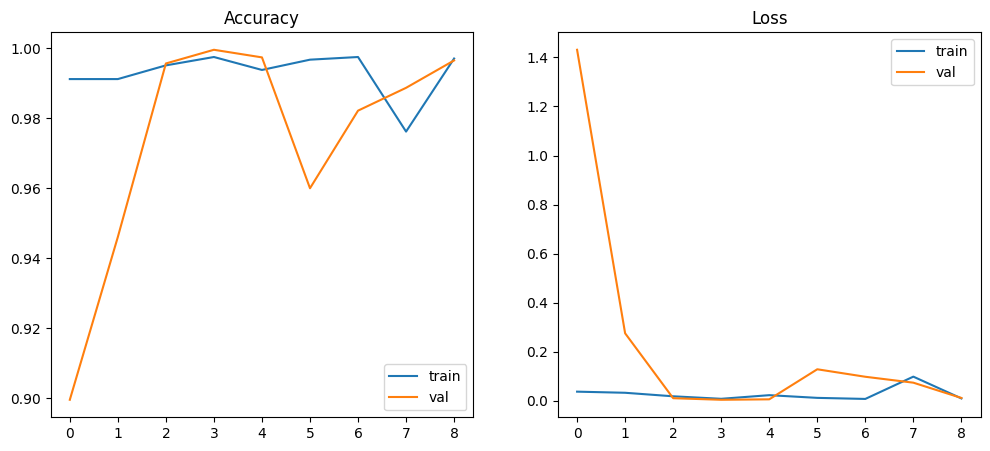

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.show()


1/1 [==============================] - 0s 16ms/step


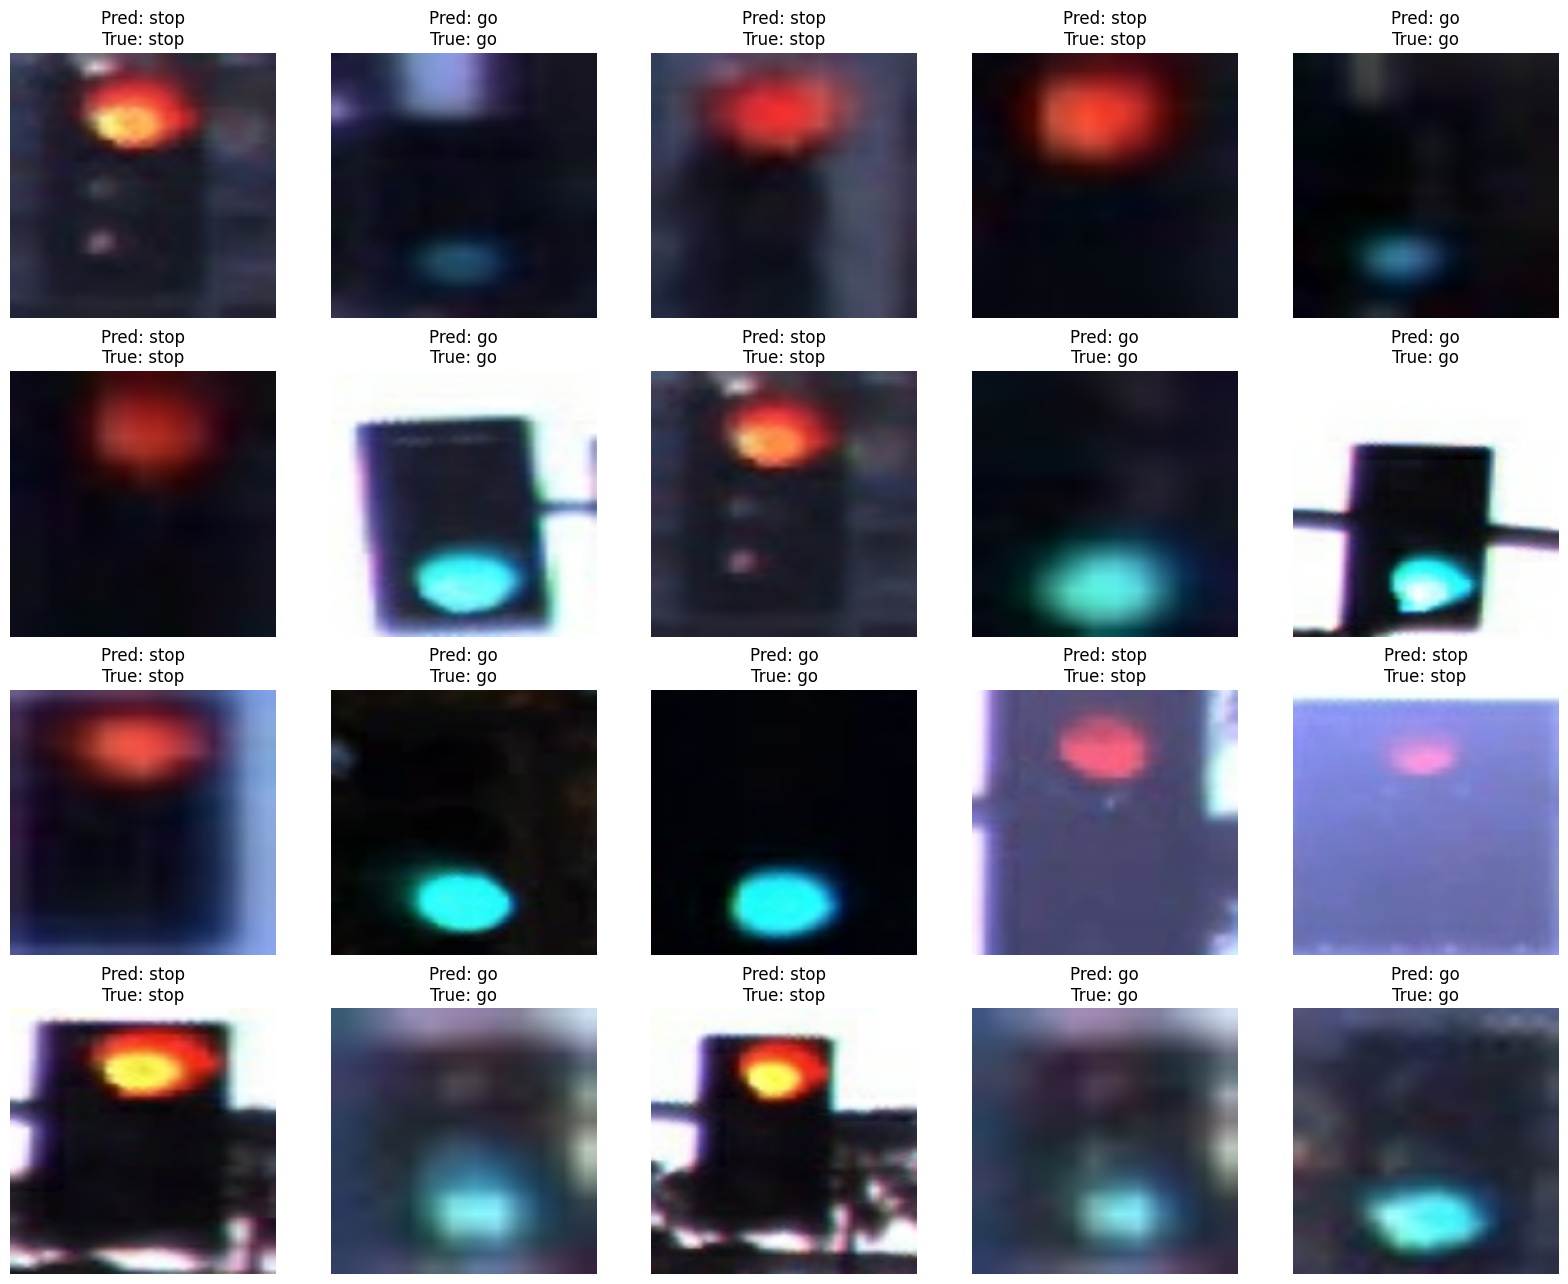

In [27]:
plt.figure(figsize=(20, 20))
for images, labels in test_dataset.take(2):  # take 1 batch
    for i in range(min(20, images.shape[0])):
        img = images[i].numpy().astype("uint8")
        label = labels[i].numpy()

        pred = model.predict(tf.expand_dims(images[i], 0))
        pred_label = class_names[np.argmax(pred)]
        true_label = class_names[label]

        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis("off")
plt.show()
